In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.colors as mcolors
from tqdm import tqdm

In [2]:
# Config
SELECTED_STATIONS = [3, 9]  # change this to try different station sets

# Load processed dataset
cols = ['Date','Hour','Load'] + [f'w{i}' for i in range(1,26)]
df = pd.read_csv('./processed_data/GEFCom2014.csv', usecols=cols)

# Build time column from Date and Hour
# Date format: '1/1/2001', Hour format: 1..24; interpret hour-1 as 0..23
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df = df.dropna(subset=['Hour'])
df['Hour'] = df['Hour'].astype(int)

# Convert to datetime
base_dt = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['time'] = base_dt + pd.to_timedelta(df['Hour'] - 1, unit='h')

# Drop initial rows with missing LOAD and coerce numeric
df['LOAD'] = pd.to_numeric(df['Load'], errors='coerce')
df = df.dropna(subset=['LOAD'])

station_cols = [f'w{i}' for i in SELECTED_STATIONS]
df['TEMP_AVG'] = df[station_cols].mean(axis=1)

df = df.sort_values('time')[['time','LOAD','TEMP_AVG']]
print(f"Rows loaded: {len(df)} | Time span: {df['time'].min()} to {df['time'].max()} | Stations: {SELECTED_STATIONS}")


Rows loaded: 61344 | Time span: 2005-01-01 00:00:00 to 2011-12-31 23:00:00 | Stations: [3, 9]


In [3]:
# Output directory for plots
plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)

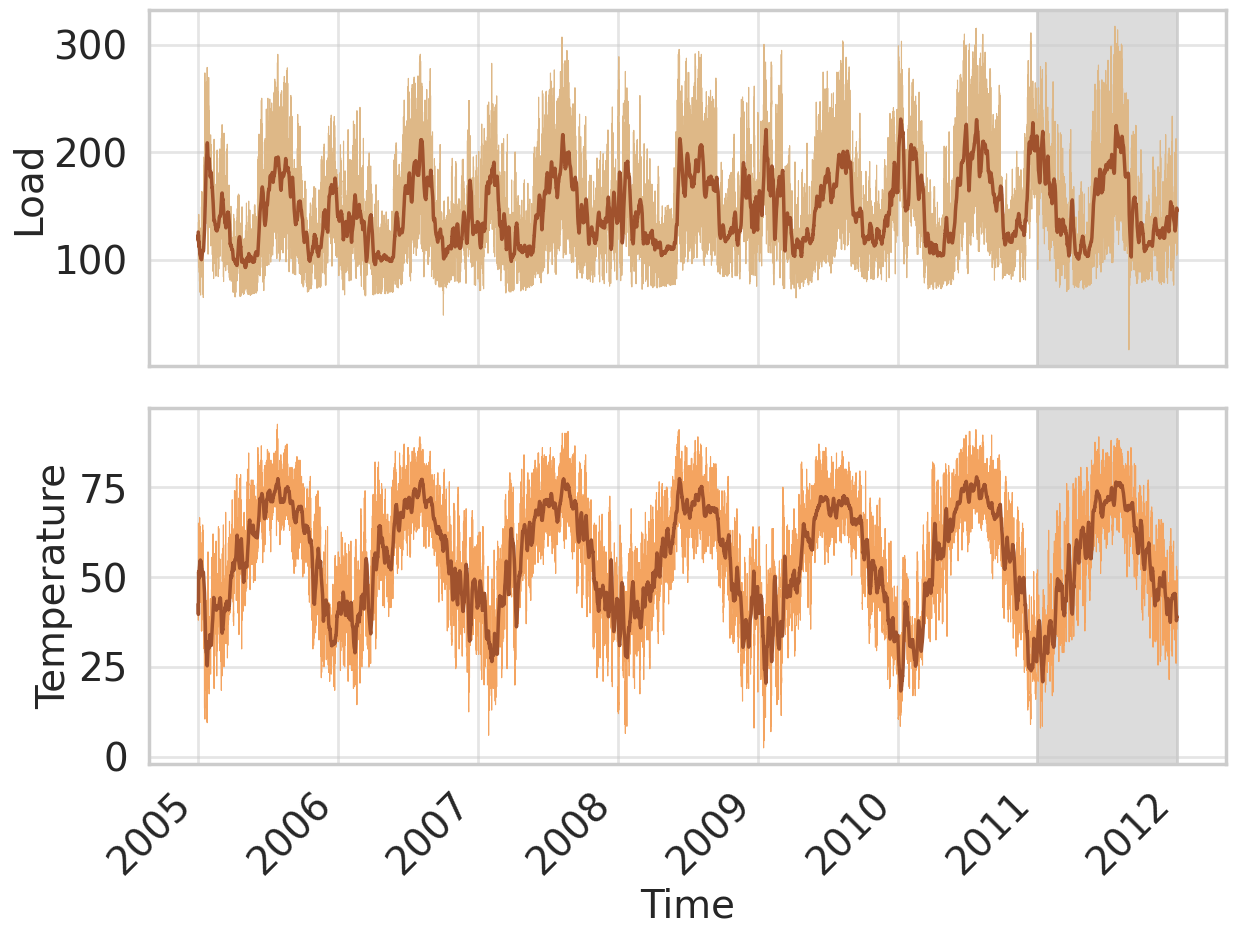

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid', {'grid.linestyle': '-', 'grid.alpha': 0.4})
sns.set_context('poster')

ROLLING_WINDOW = 24 * 7     # e.g., 24 for 24-sample rolling mean; set to None to disable
LOAD_COLOR = "burlywood"    # light brown for the raw LOAD series
TEMP_COLOR = "sandybrown"   # light orange for the raw TEMP series
ROLL_LOAD_COLOR = "sienna"  # dark brown for the rolling mean
FONT_SIZE = 28
LINEWIDTH = 0.8
ROLL_LINEWIDTH = 2.5
GRID_STYLE = {"which": "both", "linestyle": "-", "alpha": 0.5}

try:
    stations_label = f" (Stations {SELECTED_STATIONS})"
except NameError:
    stations_label = ""

plt.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "axes.titlesize": FONT_SIZE + 1,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE - 1,
})

if not pd.api.types.is_datetime64_any_dtype(df["time"]):
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time")

if ROLLING_WINDOW is not None and ROLLING_WINDOW > 1:
    load_roll = df["LOAD"].rolling(ROLLING_WINDOW, min_periods=1).mean()
    temp_roll = df["TEMP_AVG"].rolling(ROLLING_WINDOW, min_periods=1).mean()
else:
    load_roll = None
    temp_roll = None

fig, axes = ig, axes = plt.subplots(2, 1, figsize=(13, 10), sharex=True,)

# 1) Load vs Time
axes[0].plot(df["time"], df["LOAD"], label="Load", linewidth=LINEWIDTH, color=LOAD_COLOR)
if load_roll is not None:
    axes[0].plot(df["time"], load_roll, label=f"Load (Rolling mean, w={ROLLING_WINDOW})", linewidth=ROLL_LINEWIDTH, color=ROLL_LOAD_COLOR)
axes[0].set_ylabel("Load")
axes[0].grid(**GRID_STYLE)

# 2) Temp vs Time
axes[1].plot(df["time"], df["TEMP_AVG"], label="Average Temperature", linewidth=LINEWIDTH, color=TEMP_COLOR)
if temp_roll is not None:
    axes[1].plot(df["time"], temp_roll, label=f"Temp (Rolling mean, w={ROLLING_WINDOW})", linewidth=ROLL_LINEWIDTH, color=ROLL_LOAD_COLOR)
axes[1].set_ylabel("Temperature")
axes[1].set_xlabel("Time")
axes[1].grid(**GRID_STYLE)

fig.autofmt_xdate(rotation=45, ha='right')

cutoff = pd.Timestamp("2011-01-01")
tmax = df["time"].max()

for ax in axes:
    ax.axvspan(cutoff, tmax, color="#bbb", alpha=0.5, zorder=0)

plt.tight_layout()
out_pdf = f"{plots_dir}/load_temp_timeseries.pdf"
plt.savefig(out_pdf, dpi=300, bbox_inches="tight")

plt.show()